# Improving public policy by predicting car accident severity using machine learning
---
2020 - [José Oliveira da Cruz](https://github.com/joseferncruz/coursera-capstone)

**Disclaimer:** _This notebook is part of the Coursera Capstone Project to complete the [IBM Certification in Data Science](https://www.coursera.org/professional-certificates/ibm-data-science). All project ideas are fictitious and serve only the purpose of developing a data science project._


Original dataset: [link_dataset](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv)  
Metadata: [link_metadata](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)


**The written report associated with this project can be found [here](https://docs.google.com/document/d/15EvVyyEokxCvwtYD3CShfXqDteALbU_kGJTnf0WRIVI/edit#).**



## Table of Contents
---
### 1 - [Introduction/Business Problem](#business-und)

### 2 - [Data understanding and Data Preparation](#data-und-data-prep)

### 3 - [Modeling](#modeling)

### 4 - [Evaluation](#evaluation)

### 5 - [Conclusion](#conclusion)

<a id="business-und"><a/>

# 1 - Introduction/Business Problem
---- 


Predicting accident severity in US cities based on specific metrics can be a powerful tool to drive public policy and reduce overall accident rate. In Seattle – Washington, the Department of Transport/Traffic Management Division,  has been collecting data since 2004 about collisions in the metropolitan area with the objective of creating a complete database that represents the overall road accidents involving collisions in this city. The City Council of Seattle has the responsibility of approving the city's budget, and develops laws and policies intended to promote safety of Seattle's residents  . During every fiscal year, the city council discusses policies to improve road safety in Seattle by reducing the number of human injuries involved in those accidents. 
    
In this data science project, I proposed to develop a model that can distinguish accidents resulting in human injuries from accidents resulting in property damage-only. This prediction will be based on widely available metrics provided by the Department of transport and it can help to identify which factors may increase the risk for injury-related accidents and help develop actions to reduce those. The successful outcome of this project would be a model that can predict with accuracy accidents associated with human costs (i.e. high true positive rate), so that actions can be developed to minimize those costs. Examples of actions could include target advertising for road safety, improve road design, increase police deployment to secure roads, increase fines for reckless driving, among others. 


In [1]:
##### Import necessary packages
import sklearn
import numpy as np
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')
plt.rcParams['axes.titlesize'] = 14

In [2]:
# specify the location of the data
data_url = 'https://github.com/joseferncruz/coursera-capstone/raw/master/datasets/collisions_data.csv'

#load the data into a dataframe
df_raw = pd.read_csv(
    data_url,
    parse_dates=['INCDTTM', 'INCDATE'], # Parse dates to datetime objects 
    usecols=[
        'SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'PERSONCOUNT', 'PEDCOUNT',
        'PEDCYLCOUNT', 'VEHCOUNT', 'INCDTTM', 'JUNCTIONTYPE', 'WEATHER',
        'ROADCOND', 'LIGHTCOND', 'CROSSWALKKEY', 'INCDATE',
    ],
    low_memory=False,
);

df_raw.drop(columns='INCDATE', inplace=True)

<a id="data-und-data-prep"><a/>

# 2 - Data understanding and Data Preparation
---
    
To develop my data project, I will use data about collisions provided by Seattle Police Department and recorded by Traffic Records[1]. This dataset includes all types of collisions happening at intersection or mid-block of a road segment since 2004 and contains information about many important factors such as road condition and lightning conditions, weather, segment of the road involved (among other) and associated with each accident there is a variable that represents the outcome severity with 2 values: type 1 – property damage-only and type 2 – Injury-related. This dataset is also suitable to perform some feature engineering. For instance, the dataset records the time of the day and date of the accident. By using this information, we can check whether certain accidents happen more frequently during rush hour or during specific months of the year.  By using this information, I will develop a classification model aiming at predicting the severity outcome of the accident, with particular emphasis at predicting type 2 accidents.  I will focus on optimizing the model to get a high true positive rate of detection of type 2 accidents and the results obtained from this model could guide actions to decrease the occurrence of these accidents.

In order to solve this classification problem, I will use the following features from the original dataset:


|Attributes| Description|  
|---:|:----|  
|SEVERITYCODE|A code that corresponds to the severity of the collision|  
| X | GPS Longitude coordinate |
| Y | GPS Latitude coordinate | 
|ADDRTYPE|Collision address type|
|PERSONCOUNT|The total number of people involved in the collision|
|PEDCOUNT|The number of pedestrians involved in the collision |
|PEDCYLCOUNT| The number of bicycles involved in the collision. |
|VEHCOUNT|The number of vehicles involved in the collision|
|INCDTTM|The date and time of the incident.|
| JUNCTIONTYPE| Category of junction at which collision took place |
|WEATHER|A description of the weather conditions during the time of the collision|
|ROADCOND|The condition of the road during the collision|
|LIGHTCOND|The light conditions during the collision|
|CROSSWALKKEY| A key for the crosswalk at which the collision occurred |


Let's start by exploring the features and characteristics of this dataset.

In [3]:
print(f'This dataset has {df_raw.shape[0]} rows and {df_raw.shape[1]} columns, including one target column.')

This dataset has 194673 rows and 14 columns, including one target column.


In [4]:
# Drop columns not used in this case study
df = df_raw.copy()

# display some information about the datatypes and number of entries associated with the full raw dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   SEVERITYCODE  194673 non-null  int64         
 1   X             189339 non-null  float64       
 2   Y             189339 non-null  float64       
 3   ADDRTYPE      192747 non-null  object        
 4   PERSONCOUNT   194673 non-null  int64         
 5   PEDCOUNT      194673 non-null  int64         
 6   PEDCYLCOUNT   194673 non-null  int64         
 7   VEHCOUNT      194673 non-null  int64         
 8   INCDTTM       194673 non-null  datetime64[ns]
 9   JUNCTIONTYPE  188344 non-null  object        
 10  WEATHER       189592 non-null  object        
 11  ROADCOND      189661 non-null  object        
 12  LIGHTCOND     189503 non-null  object        
 13  CROSSWALKKEY  194673 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 

By exploring the metadata, it is possible to notice that some columns have large quantities of missing data or lack information (Not Enough Information or NEI). Also our model should be able to predict accident severity based on features (ie information) that can be measured in real time or within an hour range (eg weather, road condition, etc).

The first step is to deal with the missing/unknown information from columns in order to reduce the uncertainty around certain features.

In [5]:
df.isna().sum()

SEVERITYCODE       0
X               5334
Y               5334
ADDRTYPE        1926
PERSONCOUNT        0
PEDCOUNT           0
PEDCYLCOUNT        0
VEHCOUNT           0
INCDTTM            0
JUNCTIONTYPE    6329
WEATHER         5081
ROADCOND        5012
LIGHTCOND       5170
CROSSWALKKEY       0
dtype: int64

In [6]:
# Remove entries with missing information

# Remove missing/uncertain values from WEATHER
df['WEATHER'].replace(['Unknown', 'Other'], 'uncertain', inplace=True)
df['WEATHER'].fillna(value='uncertain', inplace=True)

# Remove missing/uncertain values from ROADCOND
df['ROADCOND'].replace(['Unknown', 'Other'], 'uncertain', inplace=True)
df['ROADCOND'].fillna(value='uncertain', inplace=True)

# Remove missing/uncertain values from LIGHTCOND
df['LIGHTCOND'].replace(['Unknown', 'Other', 'Dark - Unknown Lighting'], 'uncertain', inplace=True)
df['LIGHTCOND'].fillna(value='uncertain', inplace=True)

# JUNTIONTYPE
df['JUNCTIONTYPE'].replace(['Unknown'], 'uncertain', inplace=True)
df['JUNCTIONTYPE'].fillna(value='uncertain', inplace=True)

# ADDRTYPE
df[df.ADDRTYPE.isna()] = 'NaN'
df['ADDRTYPE'].replace(['NaN'], 'uncertain', inplace=True)

# Drop NaN from target variable.
df['SEVERITYCODE'].replace('NaN', np.nan, inplace=True)
df = df.loc[~df.SEVERITYCODE.isna(), :]

# GPS coords - substitute missing GPS coords with median value.
df[['X', 'Y']].replace('NaN', np.nan, inplace=True)
df['X'].fillna(np.median(df.X), inplace=True)
df['Y'].fillna(np.median(df.Y), inplace=True)

# Consider only complete years
#Extract the hour
df['YEAR'] = df['INCDTTM'].dt.year
# remove faulty entries (ie not correct hour record)
cond = df['YEAR'].isin([2020])
df = df.loc[~cond, :].copy()


C:\Users\josec\anaconda3\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [7]:
# Display information about the dataset without missing data or incomplete information.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190505 entries, 0 to 194672
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   SEVERITYCODE  190505 non-null  float64
 1   X             190505 non-null  float64
 2   Y             190505 non-null  float64
 3   ADDRTYPE      190505 non-null  object 
 4   PERSONCOUNT   190505 non-null  object 
 5   PEDCOUNT      190505 non-null  object 
 6   PEDCYLCOUNT   190505 non-null  object 
 7   VEHCOUNT      190505 non-null  object 
 8   INCDTTM       190505 non-null  object 
 9   JUNCTIONTYPE  190505 non-null  object 
 10  WEATHER       190505 non-null  object 
 11  ROADCOND      190505 non-null  object 
 12  LIGHTCOND     190505 non-null  object 
 13  CROSSWALKKEY  190505 non-null  object 
 14  YEAR          190505 non-null  int64  
dtypes: float64(3), int64(1), object(11)
memory usage: 23.3+ MB


The `SEVERITYCODE` target variable can take 2 values (1/2):
- 1: **Property Damage**  
- 2: **Injury**




In [8]:
# How many observations per target category exists?
for category, counts in df.SEVERITYCODE.value_counts().items():
    print(f"There are {counts} elements in target value {category}.")
    
# Print normalized count in each category of severity.
norm_count = df.SEVERITYCODE.value_counts(normalize=True).to_dict()
print(f"The dataset is devided into{norm_count.get(1)*100: 0.2f}% Severity 1 and{norm_count.get(2)*100: 0.2f}% Severity 2 observations.")

There are 133191 elements in target value 1.0.
There are 57314 elements in target value 2.0.
The dataset is devided into 69.91% Severity 1 and 30.09% Severity 2 observations.


As it is possible to observe, our dataset is quite imbalanced and this poses a challenge to classification algorithms. For now, we will consider the full dataset (i.e. records without missing or ambiguous information) and I will address later the problem of the imbalanced data.

## Location of type 1 and type 2 severity events in the city of Seattle
---

Since we have GPS Data, the first step will be to cluster the city of Seattle into 10 different spatial clusters and identify those clusters. This information can also be relevant for the sponsors to target their actions to reduce accident severity.

In [9]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INCDTTM', 'JUNCTIONTYPE', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'CROSSWALKKEY', 'YEAR'],
      dtype='object')

### Divide the city of Seattle into 12 clusters

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
from sklearn.cluster import KMeans

# Initiate KMeans for 10 clusters (ie putative city areas)
kmeans = KMeans(n_clusters = 12, init ='k-means++', random_state=32)

# Get coords dataframe
coords = df[['X', 'Y']]

# Fit the model
kmeans.fit(coords) # Compute k-means clustering.

# get the labels
labels = kmeans.predict(coords) # Labels of each point

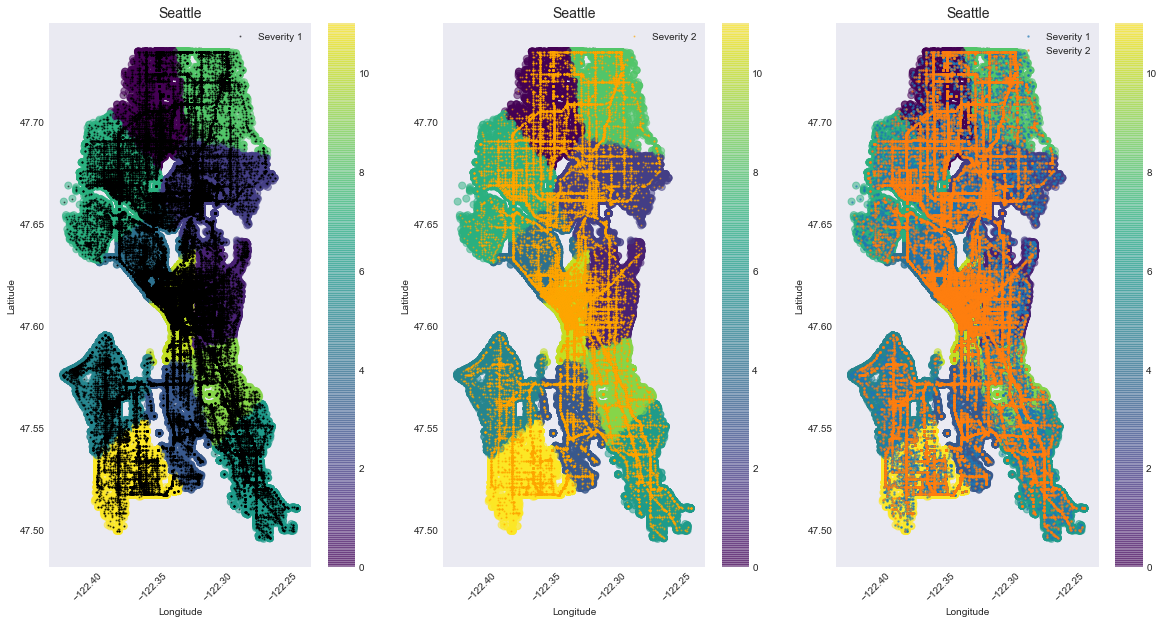

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Set condition to access both types of severity independently
cond = df['SEVERITYCODE'] == 1

# Class 1
ax[0].plot(df['X'][cond], df['Y'][cond], '.', ms=2, alpha=0.5, color='black')
ax[0].set(ylabel='Latitude')
ax[0].legend(labels=['Severity 1'])

# Class 2
ax[1].plot(df['X'][~cond], df['Y'][~cond], '.', ms=2, color='orange', alpha=0.5)
ax[1].legend(labels=['Severity 2'])

# Both 1 and 2
for event_type in [1, 2]:
    ax[2].plot(df['X'][df['SEVERITYCODE'] == event_type], df['Y'][df['SEVERITYCODE'] == event_type], '.', ms=3, alpha=0.5)
ax[2].legend(labels=['Severity 1', 'Severity 2'], loc='upper right')

# Complete plot info
for idx in range(3):
    coords.plot.scatter(x = 'X', y = 'Y', c=labels, s=50, cmap='viridis', ax=ax[idx], alpha=0.5)
    ax[idx].set(title='Seattle')
    ax[idx].set(xlabel='Longitude', ylabel='Latitude')
    ax[idx].tick_params('x', labelrotation=45)
    
    

In [13]:
# Create a new feature: `SECTOR_ID` with labels from the clustering algorithm.
df['SECTOR_ID'] = labels

In [14]:
# Check the total numbe of severity 1 and 2 events for each sector
result = df.groupby(['SEVERITYCODE'])['SECTOR_ID'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()
result.sort_values('NORM_COUNT', inplace=True)

[Text(0.5, 1.0, 'Accident severity across city clusters')]

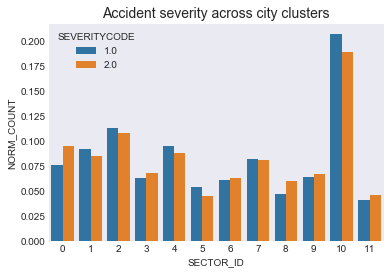

In [15]:
fig, ax = plt.subplots()
sns.barplot(x='SECTOR_ID', y='NORM_COUNT', data=result, hue='SEVERITYCODE', ax=ax)
ax.set(title='Accident severity across city clusters')

## When do events of specific severities happen more often?
---
In order to answer this question, we need to create new time features from the time feature in `INCDTTM`.

In [16]:
# Extract the week day
df['WEEKDAY'] = df['INCDTTM'].dt.weekday

# Extract the hour
df['HOUR'] = df['INCDTTM'].dt.hour

# Extrack the month
df['MONTH'] = df['INCDTTM'].dt.month

# Extract the year
df['YEAR'] = df['INCDTTM'].dt.year

# Display top 3 columns
df.head(3)

,SEVERITYCODE,X,Y,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,CROSSWALKKEY,YEAR,SECTOR_ID,WEEKDAY,HOUR,MONTH
0,2.0,-122.323148,47.703140,Intersection,2,0,0,2,2013-03-27 14:54:00,At Intersection (intersection related),Overcast,Wet,Daylight,0,2013,8,2,14,3
1,1.0,-122.347294,47.647172,Block,2,0,0,2,2006-12-20 18:55:00,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,0,2006,4,2,18,12
2,1.0,-122.334540,47.607871,Block,4,0,0,3,2004-11-18 10:20:00,Mid-Block (not related to intersection),Overcast,Dry,Daylight,0,2004,10,3,10,11


### Evolution of the total number of accidents for each category since 2004:

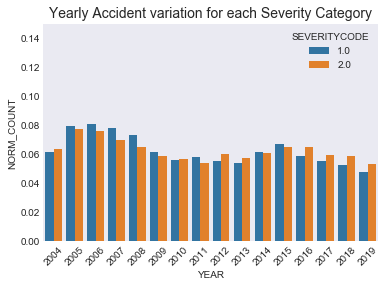

In [17]:
# Extract monthly normalized count of events for each category
result = df.groupby('SEVERITYCODE')['YEAR'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()
sns.barplot(x='YEAR', y='NORM_COUNT', data=result, hue='SEVERITYCODE', ax=ax)

ax.set(ylim=(0, 0.15), title='Yearly Accident variation for each Severity Category');
ax.tick_params('x', labelrotation=45)

It seems that accidents of type 2 tend to be more frequent since 2016. It is also interesting to notice an overall decrease in the number of accidents over the years. We can create a variable `SINCE_2016` that captures this information:

In [18]:
df['SINCE_2016'] = df['YEAR'].apply(lambda x: 1 if x >= 2016 else 0)

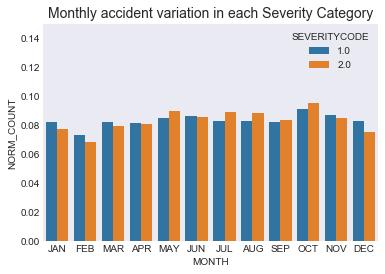

In [19]:
# Extract monthly normalized count of events for each category
result = df.groupby('SEVERITYCODE')['MONTH'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()
sns.barplot(x='MONTH', y='NORM_COUNT', data=result, hue='SEVERITYCODE', ax=ax)

month_labels = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ax.set(ylim=(0, 0.15), xticklabels=month_labels, title='Monthly accident variation in each Severity Category');

It seems that **JULY** and **AUGUST** have a (low, but still) slightly higher proportion of accidents in the category 2. We could use this information to create one additional one-hot encoded variable `SUMMER`.

In [20]:
df['SUMMER'] = df['MONTH'].apply(lambda x: 1 if x in [6, 7] else 0)

In [21]:
# Show the proportion.
df.groupby('SEVERITYCODE')['SUMMER'].value_counts(normalize=True)

SEVERITYCODE  SUMMER
1.0           0         0.830492
              1         0.169508
2.0           0         0.825104
              1         0.174896
Name: SUMMER, dtype: float64

## What about daily the variation in accident severity? Is there a particular time of the day with a higher proportion of accidents belonging to a specific severity type?
----


[Text(0.5, 1.0, 'Hourly accident proportion in each severity Category')]

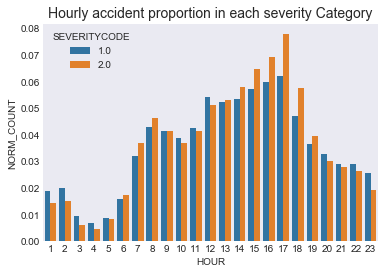

In [22]:
# Estract normalized count of each severity category for each hour
result = df.groupby('SEVERITYCODE')['HOUR'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()

fig, ax = plt.subplots()

sns.barplot(x='HOUR', y='NORM_COUNT', data=result.loc[~(result['HOUR'] == 0)], hue='SEVERITYCODE', ax=ax)

ax.set(title='Hourly accident proportion in each severity Category')

It seems that during the rush hour (7-8AM, 4-6PM) there is a higher proportion of accidents belonging to category 2, particularly during the rush hour (5-7PM). Let's capture this variation in another one-hot encoded variable `RUSH_HOUR`.

In [23]:
df['RUSH_HOUR'] = df['HOUR'].apply(lambda x: 1 if x in [7, 8, 16, 17, 18] else 0)

df.groupby('SEVERITYCODE')['RUSH_HOUR'].value_counts(normalize=True)

SEVERITYCODE  RUSH_HOUR
1.0           0            0.755704
              1            0.244296
2.0           0            0.711624
              1            0.288376
Name: RUSH_HOUR, dtype: float64

## What is the average human cost associated with each city sector?
---
In order to maximize the clustering information, it would be good to find a measure of human cost that could be used to describe each individual group (ie `SECTOR_ID`). One way to do this is to explore a measurement of the ratio between humans vs vehicles involved.


In [24]:
# Create a single column that agregates all the non-motorized human involvement
df['TOTAL_HUMAN'] = df[['PERSONCOUNT', 'PEDCYLCOUNT', 'PEDCOUNT']].sum(axis=1)
df['TOTAL_HUMAN'].head()

0    2.0
1    2.0
2    4.0
3    3.0
4    2.0
Name: TOTAL_HUMAN, dtype: float64

## What is the relationship between total number of people involved and total number of vehicles involved?  
---

Before dwelling into the relation, let's have a look at the distribution of values within each variable.

In [25]:
# Some stats about severity and location
df.groupby(['SEVERITYCODE'])[['VEHCOUNT', 'TOTAL_HUMAN']].agg([np.mean, np.min, np.max])

TOTAL_HUMAN           
                    mean amin  amax
SEVERITYCODE                       
1.0             2.344625  0.0  57.0
2.0             2.915902  0.0  81.0

It seems that a higher number of people is associated with a severity of type 2, although the mean is only slightly lower. Let's look at the distribution.

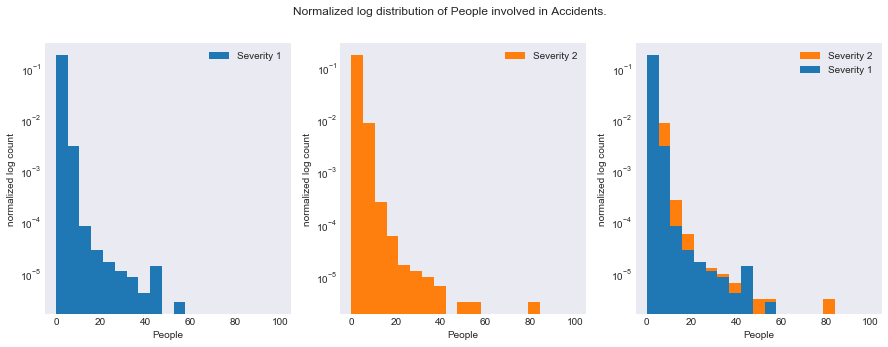

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Normalized log distribution of People involved in Accidents.')

bins = np.linspace(0, 100, 20)

ax[0].hist(df['TOTAL_HUMAN'][df['SEVERITYCODE']==1], bins=bins, color='#1f77b4', label='Severity 1', log=True, density=True);
ax[1].hist(df['TOTAL_HUMAN'][df['SEVERITYCODE']==2], bins=bins, color='#ff7f0e', label='Severity 2', log=True, density=True);

ax[2].hist(df['TOTAL_HUMAN'][df['SEVERITYCODE']==2], log=True, bins=bins, color='#ff7f0e', label='Severity 2', density=True);
ax[2].hist(df['TOTAL_HUMAN'][df['SEVERITYCODE']==1], log=True, bins=bins, color='#1f77b4', label='Severity 1', density=True);


for idx in range(3):
    ax[idx].legend()
    ax[idx].set(ylabel='normalized log count', xlabel='People')

According to the plot above (normalize to total count and in logarithmic scale) it is possible to observe that category 2 accidents involve frequently more humans than type 1.


In [27]:
# Convert vehcount into int datatype
df['VEHCOUNT'] = df.VEHCOUNT.astype(int)

result = df.groupby(['SEVERITYCODE', 'SECTOR_ID']).mean()[['TOTAL_HUMAN', 'VEHCOUNT']].reset_index()


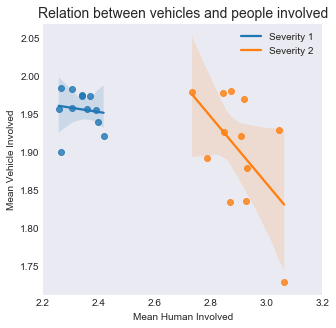

In [28]:
# Plot the relation between total number of people involved vs vehicles.
fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    x='TOTAL_HUMAN',
    y='VEHCOUNT',
    data=result[result.SEVERITYCODE==1],
    order=1,
    ax=ax
)

sns.regplot(
    x='TOTAL_HUMAN',
    y='VEHCOUNT',
    data=result[result.SEVERITYCODE==2],
    order=1,
    ax=ax
)

ax.set(
    ylabel='Mean Vehicle Involved',
    xlabel='Mean Human Involved',
    title='Relation between vehicles and people involved',
    xlim=(2.2, 3.2)
)
ax.legend(labels=['Severity 1', 'Severity 2'])


### Are the two variables correlated?
----
Severity type 1:

In [29]:
slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(result[result.SEVERITYCODE==1][['TOTAL_HUMAN', 'VEHCOUNT']])

print(f"The correlation coeff (person) is: {rvalue: 0.2f} and the p-value associated is {pvalue: 0.3f}")

The correlation coeff (person) is: -0.12 and the p-value associated is  0.705


Severity type 2:

In [30]:
slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(result[result.SEVERITYCODE==2][['TOTAL_HUMAN', 'VEHCOUNT']])

print(f"The correlation coeff (person) is: {rvalue: 0.2f} and the p-value associated is {pvalue: 0.3f}")

The correlation coeff (person) is: -0.54 and the p-value associated is  0.069


The two variables are negatively correlated, meaning that there is a higher number of people associated with accidents involving fewer vehicles. 

## What is the ratio between total number of people involved and number of vehicles?
---

Let's now calculate the ratio between people involved and total intervenients involved for each observation in the dataset.

In [31]:

# Divide total_human by total_human + veh_count
df['RATIO_HUMAN/VEH'] = df['TOTAL_HUMAN'] / (df['TOTAL_HUMAN'] + df['VEHCOUNT'])

Now let's check the mean of the `RATIO_HUMAN/VEH` of each Cluster and for each severity category.

In [32]:
human_cost = df.groupby(['SEVERITYCODE', 'SECTOR_ID']).mean()['RATIO_HUMAN/VEH'].to_frame().reset_index()

human_cost.head()

,SEVERITYCODE,SECTOR_ID,RATIO_HUMAN/VEH
0,1.0,0,0.531184
1,1.0,1,0.523160
2,1.0,2,0.530760
3,1.0,3,0.524611
4,1.0,4,0.534016


Let's Create a new feature called `SECTOR_HUMAN_COST` which stores the score of human cost for each sector.

In [33]:
severity_code_1 = human_cost[human_cost['SEVERITYCODE']==1][['SECTOR_ID', 'RATIO_HUMAN/VEH']]
severity_code_1 = severity_code_1.to_dict().get('RATIO_HUMAN/VEH')

severity_code_2 = human_cost[human_cost['SEVERITYCODE']==2][['SECTOR_ID', 'RATIO_HUMAN/VEH']].reset_index()
severity_code_2 = severity_code_2.to_dict().get('RATIO_HUMAN/VEH')

In [34]:
df['SECTOR_HUMAN_COST_a'] = df[df['SEVERITYCODE']==1]['SECTOR_ID'].replace(severity_code_1)
df['SECTOR_HUMAN_COST_a'].fillna(0, inplace=True)

In [35]:
df['SECTOR_HUMAN_COST_b'] = df[df['SEVERITYCODE']==2]['SECTOR_ID'].replace(severity_code_2)
df['SECTOR_HUMAN_COST_b'].fillna(0, inplace=True)

In [36]:
df['SECTOR_HUMAN_COST'] = df['SECTOR_HUMAN_COST_a'] + df['SECTOR_HUMAN_COST_b']

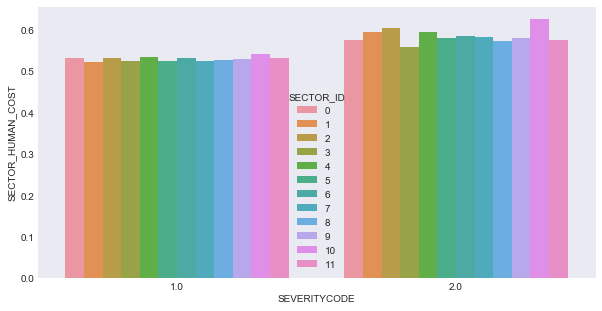

In [37]:
fig, ax = plt.subplots( figsize=(10, 5))
sns.barplot(x='SEVERITYCODE', y='SECTOR_HUMAN_COST', data=df, hue='SECTOR_ID', ax=ax)

Create an uniform value to define each cluster.


In [38]:
net_human_cost = human_cost['RATIO_HUMAN/VEH'][human_cost['SEVERITYCODE']==2].reset_index(drop=True)\
                 - human_cost['RATIO_HUMAN/VEH'][human_cost['SEVERITYCODE']==1]

In [39]:
# Set up new variable 
df['SECTOR_HUMAN_COST'] = df['SECTOR_ID'].replace(net_human_cost.to_dict())

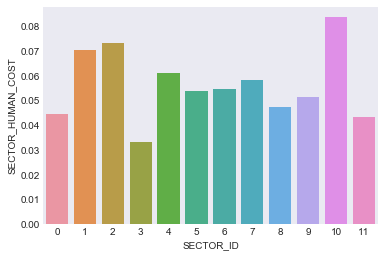

In [40]:
# Plot the results 
sns.barplot(
    x='SECTOR_ID',
    y='SECTOR_HUMAN_COST',
    data=df
)

In [41]:
df['TOTAL_INTERV'] = df['TOTAL_HUMAN'] + df['VEHCOUNT']

## Are specific types of road structures involved in specific types of events?
---
Among the data chosen to build the model, we can find information about types of collision addresses: Intersection and Block.


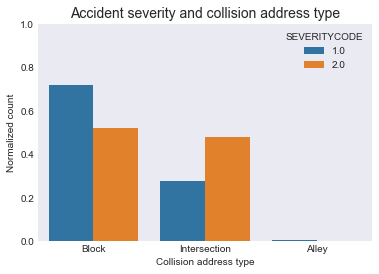

In [42]:
result = df.groupby(['SEVERITYCODE'])['ADDRTYPE'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()

fig, ax = plt.subplots()
sns.barplot(
    data=result, 
    x='ADDRTYPE', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
    ax=ax
)

ax.set(
    title='Accident severity and collision address type', 
    ylabel='Normalized count', 
    xlabel='Collision address type',
    ylim=(0, 1)
);

It seems that Severity type 2 accidents happen in equal proportions in both Blocks and Intersections whereas type 1 accidents tend to happen more in Blocks.  

## What about the road condition? How does road condition relate to accident severity?
---
There are several different attributes in terms of road condition, for instance:


In [43]:
print('Different states of road conditions', df.ROADCOND.unique())

Different states of road conditions ['Wet' 'Dry' 'uncertain' 'Snow/Slush' 'Ice' 'Sand/Mud/Dirt'
 'Standing Water' 'Oil']


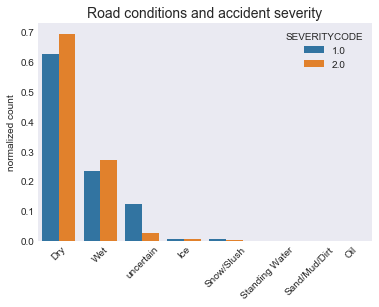

In [44]:
result = df.groupby(['SEVERITYCODE'])['ROADCOND'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='ROADCOND', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)
ax.tick_params('x', labelrotation=45)
ax.set(title='Road conditions and accident severity', ylabel='normalized count', xlabel='');

It seems that there are more accidents of category 2 during dry and wet conditions. This apparent paradox could be explained by overconfidence during dry and wet conditions that could induce reckless driving behaviors.

In [45]:
dry = ['Dry']
wet = ['Wet', 'Ice', "Snow/Slush", 'Sand/Mud/Dirt', 'Standing Water', 'Oil']


for word in wet:
    df['ROADCOND'] = df['ROADCOND'].replace(word, 'wet')
for word in dry:
    df['ROADCOND'] = df['ROADCOND'].replace(word, 'dry')
    
df.groupby('SEVERITYCODE').ROADCOND.value_counts(normalize=True)

SEVERITYCODE  ROADCOND 
1.0           dry          0.627137
              wet          0.248673
              uncertain    0.124190
2.0           dry          0.693495
              wet          0.280141
              uncertain    0.026364
Name: ROADCOND, dtype: float64

In [46]:
df.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts(normalize=True)

SEVERITYCODE  LIGHTCOND               
1.0           Daylight                    0.574724
              Dark - Street Lights On     0.252142
              uncertain                   0.116096
              Dusk                        0.029191
              Dawn                        0.012418
              Dark - No Street Lights     0.008882
              Dark - Street Lights Off    0.006547
2.0           Daylight                    0.666347
              Dark - Street Lights On     0.249782
              Dusk                        0.033639
              uncertain                   0.024793
              Dawn                        0.014220
              Dark - No Street Lights     0.005758
              Dark - Street Lights Off    0.005461
Name: LIGHTCOND, dtype: float64

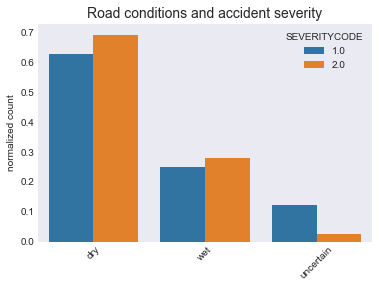

In [47]:
result = df.groupby(['SEVERITYCODE'])['ROADCOND'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='ROADCOND', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)
ax.tick_params('x', labelrotation=45)
ax.set(title='Road conditions and accident severity', ylabel='normalized count', xlabel='');

Another important component that can play a role in accident severity is the lighting conditions at the time of the accident.

## Is there any relationship between accident severity and luminosity at the time of the accident?
---
Similarly to road condition, there are several different values associated with this feature.


In [48]:
df.groupby('SEVERITYCODE').LIGHTCOND.value_counts(normalize=True)

SEVERITYCODE  LIGHTCOND               
1.0           Daylight                    0.574724
              Dark - Street Lights On     0.252142
              uncertain                   0.116096
              Dusk                        0.029191
              Dawn                        0.012418
              Dark - No Street Lights     0.008882
              Dark - Street Lights Off    0.006547
2.0           Daylight                    0.666347
              Dark - Street Lights On     0.249782
              Dusk                        0.033639
              uncertain                   0.024793
              Dawn                        0.014220
              Dark - No Street Lights     0.005758
              Dark - Street Lights Off    0.005461
Name: LIGHTCOND, dtype: float64

[Text(0, 0.5, 'normalized count'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Road conditions and accident severity')]

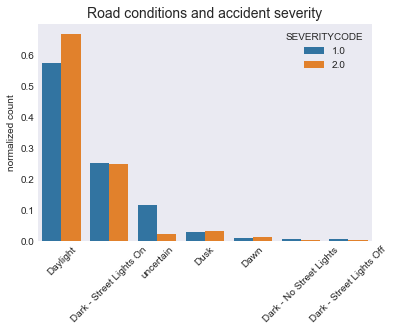

In [49]:
result = df.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='LIGHTCOND', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)
ax.tick_params('x', labelrotation=45)
ax.set(title='Road conditions and accident severity', ylabel='normalized count', xlabel='')

Let's bin the values by good and bad visibility conditions.


In [50]:
# Group by similar condtions
day_light = ['Daylight']
low_light = ['Dark - Street Lights On', 'Dusk', 'Dawn', 'Dark - No Street Lights', 'Dark - Street Lights Off']

for word in day_light:
    df['LIGHTCOND'] = df['LIGHTCOND'].replace(word, 'light-good')
for word in low_light:
    df['LIGHTCOND'] = df['LIGHTCOND'].replace(word, 'light-bad')
    
df.LIGHTCOND.unique()

array(['light-good', 'light-bad', 'uncertain'], dtype=object)

[(0, 1),
 Text(0, 0.5, 'normalized count'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Light conditions and accident severity')]

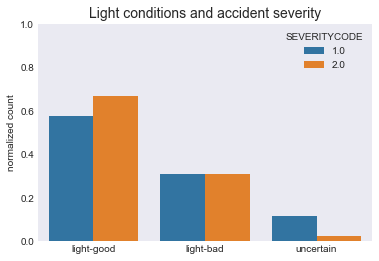

In [51]:
result = df.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='LIGHTCOND', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)

ax.set(ylim=(0, 1), title='Light conditions and accident severity', ylabel='normalized count', xlabel='')

It seems that good lightning conditions have a higher proportion of accidents of type 2 (i.e. injury-related). It could be explained by the higher number of people on the streets during daylight.



While we have observed that Intersections have a higher proportion of type 1 accidents, We can explore the feature `JUNCTIONTYPE` to extract more insights about the properties of the accidents.


In [52]:
# Junction Type
df.groupby('SEVERITYCODE').JUNCTIONTYPE.value_counts(normalize=True)

SEVERITYCODE  JUNCTIONTYPE                                     
1.0           Mid-Block (not related to intersection)              0.520110
              At Intersection (intersection related)               0.263599
              Mid-Block (but intersection related)                 0.115571
              Driveway Junction                                    0.055251
              uncertain                                            0.033576
              At Intersection (but not related to intersection)    0.011052
              Ramp Junction                                        0.000841
2.0           At Intersection (intersection related)               0.467547
              Mid-Block (not related to intersection)              0.333566
              Mid-Block (but intersection related)                 0.126688
              Driveway Junction                                    0.055972
              At Intersection (but not related to intersection)    0.010870
              uncertain 

It seems that type 1 Severity Accidents happen 50% of the times at Mid-Blocks whereas type 2 accidents happen with ~48% of the times at Intersection (intersection related). Since getting higher positive rate of type 2 accidents is our priority, I will use this information to create a one-hot encoded feature `INTERSECTION_RELATED` with this information:



In [53]:
df['INTERSECTION_RELATED'] = df['JUNCTIONTYPE'].apply(lambda x: 1 if x == 'At Intersection (intersection related)' else 0)

## Accidents at Crosswalks
---
Finally and to complete this basic EDA, let's have a look at the `CROSSWALKKEY` feature. This feature holds the key of the crossroad that is associated with an accident. Let's investigate whether accidents at crosswalks are associated with specific types of accidents.


In [54]:
# Transform the variable in 1 where there is an event at crossroad (ie accident) or 0 elsewhere.
df['CROSSWALKKEY'] = df['CROSSWALKKEY'].apply(lambda x: 0 if x == 0 else 1)

df.groupby('SEVERITYCODE')['CROSSWALKKEY'].value_counts(normalize=True)

SEVERITYCODE  CROSSWALKKEY
1.0           0               0.996884
              1               0.003116
2.0           0               0.941602
              1               0.058398
Name: CROSSWALKKEY, dtype: float64

It seems that the majority of the accidents __do not__ take place at crossroads. However, severity 2 accidents tend to be associated in higher proportion to crossroads compared to severity 1 accidents.


## How is the weather forecast related to accident severity?
---
The weather is also an important aspect of safe driving conditions and can have a strong impact on the type of accidents that can occur. In our dataset, weather can have the following values:


In [55]:
df['WEATHER'].unique()

array(['Overcast', 'Raining', 'Clear', 'uncertain', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind'], dtype=object)

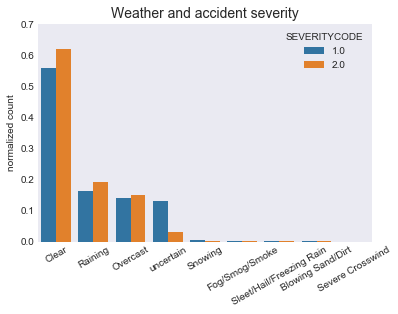

In [56]:
result = df.groupby(['SEVERITYCODE'])['WEATHER'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='WEATHER', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)

ax.set(ylim=(0, 0.7), title='Weather and accident severity', ylabel='normalized count', xlabel='');
ax.tick_params('x', labelrotation=30)

In [57]:
df.groupby('SEVERITYCODE').WEATHER.value_counts(normalize=True)

SEVERITYCODE  WEATHER                 
1.0           Clear                       0.559227
              Raining                     0.162368
              Overcast                    0.140152
              uncertain                   0.129018
              Snowing                     0.005376
              Fog/Smog/Smoke              0.002831
              Sleet/Hail/Freezing Rain    0.000616
              Blowing Sand/Dirt           0.000278
              Severe Crosswind            0.000135
2.0           Clear                       0.620512
              Raining                     0.192675
              Overcast                    0.150591
              uncertain                   0.029277
              Fog/Smog/Smoke              0.003245
              Snowing                     0.002896
              Sleet/Hail/Freezing Rain    0.000454
              Blowing Sand/Dirt           0.000227
              Severe Crosswind            0.000122
Name: WEATHER, dtype: float64

The vast majority of the accidents (>65%) happen during periods of Clear sky. Let's bin the different categories in: `sunny`, `cloudy` and `rainy-snow`.

In [58]:
# Eeather categories
sunny = ['Clear', ]
cloudy = ['Overcast', 'Fog/Smog/Smoke', 'Partly Cloudy', 'Blowing Sand/Dirt', 'Severe Crosswind', ]
rainy_snow = ['Raining', 'Snowing', 'Sleet/Hail/Freezing Rain', ]

for word in sunny:
    df['WEATHER'] = df['WEATHER'].replace(word, 'sunny')
for word in cloudy:
    df['WEATHER'] = df['WEATHER'].replace(word, 'cloudy')
for word in rainy_snow:
    df['WEATHER'] = df['WEATHER'].replace(word, 'wet')

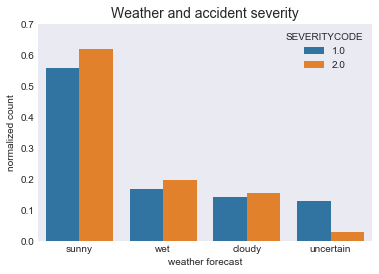

In [59]:
result = df.groupby(['SEVERITYCODE'])['WEATHER'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='WEATHER', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)

ax.set(ylim=(0, 0.7), title='Weather and accident severity', ylabel='normalized count', xlabel='weather forecast');

In agreement with the road condition variable, during sunny days (ie dry road) the amount of accidents of type 2 is higher compared to type one. It seems that wet road conditions are also associated with higher type 2 accidents.

Select and prepare data for modeling.
---

In [60]:
df = df[['SEVERITYCODE', 'ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'CROSSWALKKEY',
         'WEEKDAY', 'MONTH', 'INTERSECTION_RELATED', 'SECTOR_ID',
         'RUSH_HOUR', 'SUMMER', 'TOTAL_HUMAN', 'SECTOR_HUMAN_COST']]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190505 entries, 0 to 194672
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SEVERITYCODE          190505 non-null  float64
 1   ADDRTYPE              190505 non-null  object 
 2   WEATHER               190505 non-null  object 
 3   ROADCOND              190505 non-null  object 
 4   LIGHTCOND             190505 non-null  object 
 5   CROSSWALKKEY          190505 non-null  int64  
 6   WEEKDAY               190505 non-null  int64  
 7   MONTH                 190505 non-null  int64  
 8   INTERSECTION_RELATED  190505 non-null  int64  
 9   SECTOR_ID             190505 non-null  int32  
 10  RUSH_HOUR             190505 non-null  int64  
 11  SUMMER                190505 non-null  int64  
 12  TOTAL_HUMAN           190505 non-null  float64
 13  SECTOR_HUMAN_COST     190505 non-null  float64
dtypes: float64(3), int32(1), int64(6), object(4)
memory 

### One-hot encoding of categorical data
---

In [61]:
# Select the columns to get dummies
columns_to_get_dummies = ['ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SECTOR_ID']

In [62]:
df = pd.get_dummies(df, columns=columns_to_get_dummies, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190505 entries, 0 to 194672
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   SEVERITYCODE           190505 non-null  float64
 1   CROSSWALKKEY           190505 non-null  int64  
 2   WEEKDAY                190505 non-null  int64  
 3   MONTH                  190505 non-null  int64  
 4   INTERSECTION_RELATED   190505 non-null  int64  
 5   RUSH_HOUR              190505 non-null  int64  
 6   SUMMER                 190505 non-null  int64  
 7   TOTAL_HUMAN            190505 non-null  float64
 8   SECTOR_HUMAN_COST      190505 non-null  float64
 9   ADDRTYPE_Block         190505 non-null  uint8  
 10  ADDRTYPE_Intersection  190505 non-null  uint8  
 11  WEATHER_sunny          190505 non-null  uint8  
 12  WEATHER_uncertain      190505 non-null  uint8  
 13  WEATHER_wet            190505 non-null  uint8  
 14  ROADCOND_uncertain     190505 non-nu

### Balance the dataset
---
#### Implementing a resampling method of the majority class.

In [63]:
import imblearn

In [64]:
!jupyter notebook --version

6.0.3


In [65]:
from imblearn.under_sampling import RandomUnderSampler # https://imbalanced-learn.readthedocs.io/en/stable/api.html

# Create resampling object 
rus = RandomUnderSampler(replacement=False, random_state=32, sampling_strategy='majority')

# create target bool array to subset dataset
target_cond = df.columns == 'SEVERITYCODE'

# Undersample the data
FEATURES, TARGET = rus.fit_sample(df.loc[:, ~target_cond], df.loc[:, target_cond])

# Reassemble the dataset for preprocessing
FEATURES['SEVERITYCODE'] = TARGET

# Reassign variable to df
df = FEATURES.copy()

# Show the information about undersampled dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114628 entries, 0 to 114627
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CROSSWALKKEY           114628 non-null  int64  
 1   WEEKDAY                114628 non-null  int64  
 2   MONTH                  114628 non-null  int64  
 3   INTERSECTION_RELATED   114628 non-null  int64  
 4   RUSH_HOUR              114628 non-null  int64  
 5   SUMMER                 114628 non-null  int64  
 6   TOTAL_HUMAN            114628 non-null  float64
 7   SECTOR_HUMAN_COST      114628 non-null  float64
 8   ADDRTYPE_Block         114628 non-null  uint8  
 9   ADDRTYPE_Intersection  114628 non-null  uint8  
 10  WEATHER_sunny          114628 non-null  uint8  
 11  WEATHER_uncertain      114628 non-null  uint8  
 12  WEATHER_wet            114628 non-null  uint8  
 13  ROADCOND_uncertain     114628 non-null  uint8  
 14  ROADCOND_wet           114628 non-nu

<a id="modeling"><a/>

# Modeling
---

In this problem, I intend to build a binary classifier model based on previous observations. Thus, this problems represents a supervised learning problem and in order to tackle my classification problem I will use 3 types of machine learning algorithms:

- Logistic Regression
- Gradient Boosting Classifier
- Random Forest ensemble

    

In [66]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Import preprocessing tools and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint, truncnorm, norm

## Split data into Train and Test datasets

In [67]:
from sklearn.model_selection import train_test_split

# Features used to generate the model
FEATURES = df.loc[:, df.columns != 'SEVERITYCODE']

# What is intended to be predicted
TARGET = df.loc[:, ~(df.columns != 'SEVERITYCODE')].replace({1: 0, 2: 1}).to_numpy().flatten()

# Split the data into train/test data
X_train, X_test, y_train, y_test = train_test_split(FEATURES, TARGET, random_state=32, test_size=0.40)

## Scale the data

This is an important step for many algorithms. In order to implement cross validation, I will build a pipeline using a `sklearn.pipeline` object to ensure that there is no information leakage during cross validation.

## Create dummy classifier
The purpose of the dummy classifier is to assess how much of my model prediction is attributed to chance. For that I will implement and use a dummy classifier that chooses the most frequent class.

In [68]:
from sklearn.dummy import DummyClassifier

# Create pipeline
steps = [
    ('scaler', StandardScaler()), 
    ('dummy_clf', DummyClassifier(strategy='most_frequent', random_state=32)),
]

dummy_clf = Pipeline(steps)

# Fit Data
dummy_clf.fit(X_train, y_train)

# Predict
y_dummy = dummy_clf.predict(X_test)

## Generalized Linear Model for Classification: Logistic Regression.

Let's use grid search cross validation chained with a scaler object to find the best params to our logistic regression model.

In [69]:
# list of steps for the pipeline
steps = [
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=32, max_iter=300))
]

# Assemble the pipeline for the logistic regression
logreg = Pipeline(steps)

# Implement stratified Cross Validation
Kfold = KFold(n_splits=5)

# Find the best parameters using gridsearch cross validation
params_grid = [{ 
    'logreg__solver': ['liblinear'],
    'logreg__penalty': ['l2'],
    'logreg__C': [0.01, 0.1, 1, 10]
},
    {
        'logreg__solver': ['saga'],
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': [0.01, 0.1, 1, 10]
    }
]

# Instantiate grid search cross validation object
gs_logreg = GridSearchCV(logreg, params_grid, cv=Kfold);

# Fit the model
gs_logreg.fit(X_train, y_train);

C:\Users\josec\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [70]:
print(f'The best score for the GridSearch CrossValidation was{gs_logreg.best_score_: 0.2f}')

The best score for the GridSearch CrossValidation was 0.65


In [71]:
# print the best params
gs_logreg_best_params = gs_logreg.best_params_

print(gs_logreg_best_params)

{'logreg__C': 0.01, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}


In [72]:
# The GridSearch Cross Validation automatically refits the best params so we simply need to make predictions 
y_logreg = gs_logreg.predict(X_test)

## Random Forest Classifier

Strategy:
- Pipeline with scaler and estimator
- RandomizedSearch coupled with stratified CrossValidation
-  Use estimtor refit with best parameters for prediction

In [73]:
# Initiate the Logistic regression model
steps = [
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier(random_state=32, n_jobs=-1))
]

# Build pipeline for forest
forest = Pipeline(steps)

# Implement stratified Cross Validation
kfold = KFold(n_splits=5)

# Find the best parameters using gridsearch cross validation
param_distributions = { 
    'forest__n_estimators': randint(100, 500),
    'forest__max_depth': randint(1, 6),
    'forest__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
}

# Instantiate grid search cross validation object
gs_forest = RandomizedSearchCV(forest, param_distributions, cv=Kfold);

In [74]:
# Fit the model
gs_forest.fit(X_train, y_train);

In [75]:
gs_forest.best_params_

{'forest__max_depth': 5,
 'forest__max_features': 0.292577432918432,
 'forest__n_estimators': 366}

In [76]:
# Predict
y_forest = gs_forest.predict(X_test)

## Gradient Boosting Classifier

Strategy:
- Pipeline with scaler and estimator
- RandomizedSearch coupled with stratified CrossValidation
-  Use estimtor refit with best parameters for prediction

In [77]:
# Initiate the Logistic regression model
steps = [
    ('scaler', StandardScaler()),
    ('gbrt', GradientBoostingClassifier(random_state=32))
]

# Build pipeline for forest
gbrt = Pipeline(steps)

# Implement stratified Cross Validation
kfold = KFold(n_splits=5)

# Find the best parameters using gridsearch cross validation
param_distributions = { 
    'gbrt__n_estimators': randint(100, 300),
    'gbrt__max_depth': randint(1, 5),
    'gbrt__learning_rate': uniform(0, 1),
}

# Instantiate grid search cross validation object
gs_gbrt = RandomizedSearchCV(gbrt, param_distributions, cv=Kfold);

In [78]:
# Fit the model
gs_gbrt.fit(X_train, y_train);

In [79]:
gs_gbrt.best_params_

{'gbrt__learning_rate': 0.6260279169627282,
 'gbrt__max_depth': 2,
 'gbrt__n_estimators': 147}

In [80]:
# predict
y_gbrt = gs_gbrt.predict(X_test)

<a id="evaluation"><a/>

# Evaluation
    
The objective of this project is to develop a model that predicts accurately accidents in the category 2, so that new policies can be developed to minimize those types of accidents. Thus, we want to have a model with a high True Positive Rate for Category 2 accidents.

For this binary classification problem, I will use precision and recall measurements, associated F1 scores and I will have a look at the receiver operating characteristic (ROC) curves.

In [81]:
# Import metrics
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

### F1 Scores

Let's look at the different F1 scores for each estimator:

In [82]:
print(f'   Logistic Regression: F1 Score on test set: {f1_score(y_test, y_logreg,): 0.2f}')
print(f'Random Forest Ensemble: F1 Score on test set: {f1_score(y_test, y_forest,): 0.2f}')
print(f'     Gradient Boosting: F1 Score on test set: {f1_score(y_test, y_gbrt,): 0.2f}')
print(f'      Dummy Classifier: F1 Score on test set: {f1_score(y_test, y_dummy,): 0.2f}')

   Logistic Regression: F1 Score on test set:  0.64
Random Forest Ensemble: F1 Score on test set:  0.69
     Gradient Boosting: F1 Score on test set:  0.68
      Dummy Classifier: F1 Score on test set:  0.67


### Classification Report

To better undertand the F1 scores above let's have a look at the `classification_report`.

In [83]:
target_names = ['Severity 1', 'Severity 2']

print(f"Logistic Regresion\n--------------------\n{classification_report(y_test, y_logreg, target_names=target_names)}")
print("Random Forest\n--------------------\n", classification_report(y_test, y_forest, target_names=target_names))
print("Gradient Boosting\n---------------------\n", classification_report(y_test, y_gbrt, target_names=target_names))
print("Dummy\n---------------------\n", classification_report(y_test, y_dummy, target_names=target_names))

Logistic Regresion
--------------------
              precision    recall  f1-score   support

  Severity 1       0.64      0.67      0.65     23003
  Severity 2       0.65      0.63      0.64     22849

    accuracy                           0.65     45852
   macro avg       0.65      0.65      0.65     45852
weighted avg       0.65      0.65      0.65     45852

Random Forest
--------------------
               precision    recall  f1-score   support

  Severity 1       0.70      0.58      0.63     23003
  Severity 2       0.64      0.75      0.69     22849

    accuracy                           0.66     45852
   macro avg       0.67      0.66      0.66     45852
weighted avg       0.67      0.66      0.66     45852

Gradient Boosting
---------------------
               precision    recall  f1-score   support

  Severity 1       0.68      0.62      0.65     23003
  Severity 2       0.65      0.71      0.68     22849

    accuracy                           0.66     45852
   macro av

C:\Users\josec\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

By analysing the classification report, we can observe that the Random Forest Ensemble model provides the best recall (ie True Positive Rate) for severity 2 accidents which are the accidents that we intend to primarily target and reduce. Let's have a look at the confusion matrix to have a better visual understanding:

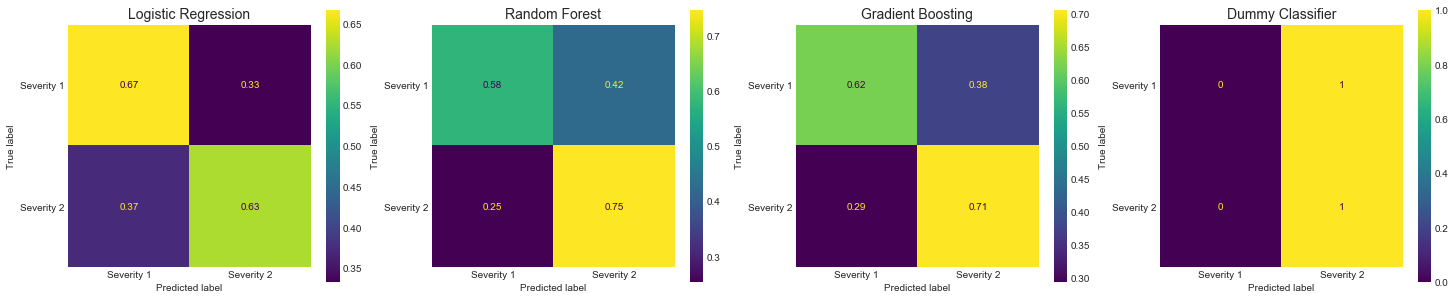

In [84]:
# Confusion Matrix
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

for idx, (name, estimator) in enumerate({'Logistic Regression': gs_logreg.best_estimator_,
                                         'Random Forest': gs_forest.best_estimator_,
                                         'Gradient Boosting': gs_gbrt.best_estimator_,
                                         'Dummy Classifier': dummy_clf,
                                        }.items()):
    plot_confusion_matrix(estimator, X_test, y_test, ax=ax[idx], normalize='true', display_labels=target_names, )
    
    ax[idx].set(title=f'{name}')

### Precision/recall curves

Another way to evaluate the best model is to have a look at the precision/recall curves. In a classification task, we can look at the tradeof of maximizing:
- recall (reduction of false negatives > accidents predicted to be of severity 1 but that are instead of severity 2)
or
- precision (reduction of false positive > accidents predicted to be of severity 2 but that are of severity 1)

In this example, we thrive to reduce false negatives (reduce the so called type 2 error) as the human cost associated with a false negative (failing to predict a type 2 severity accident) is higher than a false positive (prediction of a type 2 accident that is indeed false).

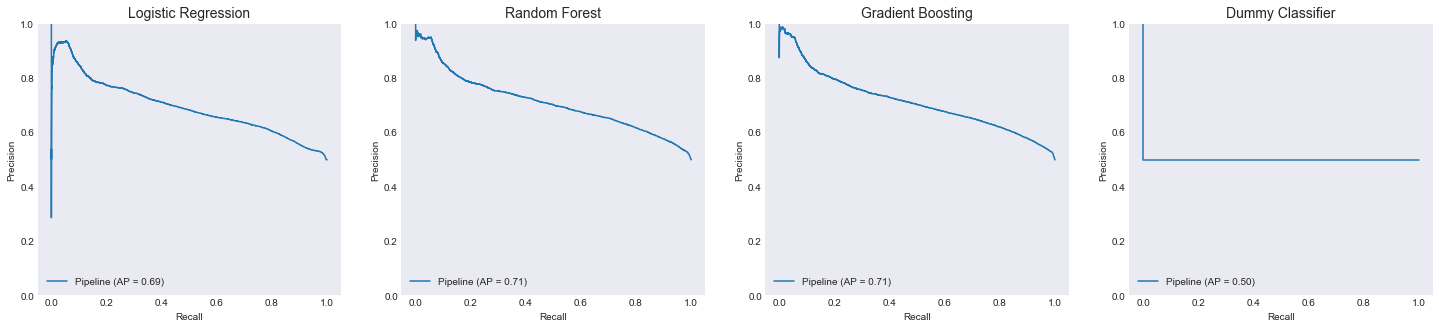

In [85]:
# Precision Recall Curves
fig, ax = plt.subplots(1, 4, figsize=(25, 5),)
for idx, (name, estimator) in enumerate({'Logistic Regression': gs_logreg.best_estimator_,
                                         'Random Forest': gs_forest.best_estimator_,
                                         'Gradient Boosting': gs_gbrt.best_estimator_,
                                         'Dummy Classifier': dummy_clf,
                                        }.items()):
    plot_precision_recall_curve(estimator, X_test, y_test, ax=ax[idx])
    ax[idx].set(title=f'{name}', ylim=(0, 1))

### Receiver Operating Curves

Another way to evaluate the performance of our classifier is to look at the receiver operating curves. An ideal ROC curve should have a high area under the curve (AUC) and should be closer to the upper left corner (High True Positive Rate: Most accidents correctly classifier in their categories + Low False Positive Rate: Small number of accidents mispredicted).

As it is possible to observe, both Random Forest and Gradient Boosting algorithms have the higher area under the curve (AUC), however based on our previous analysis, the best estimator for our problem is the Random Forest. As expected, the dummy classifier has AUC of 0.50 meaning that predictions are completely random.


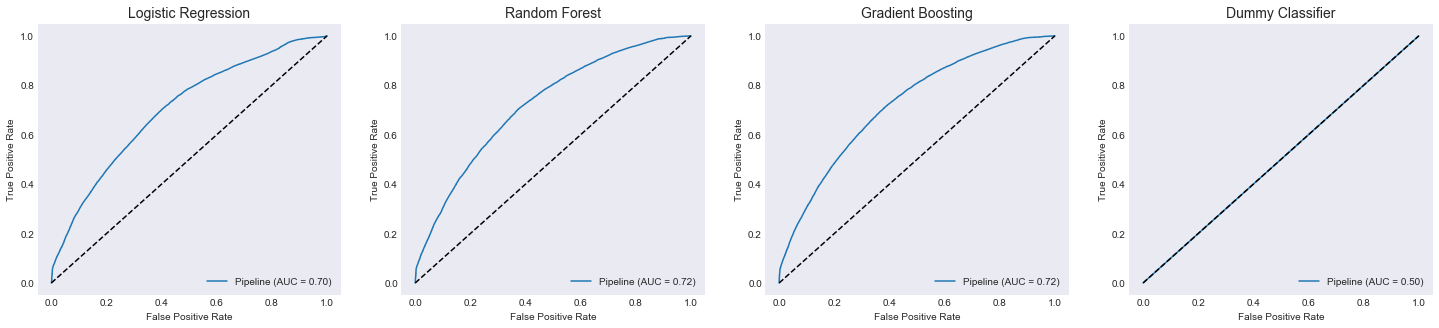

In [86]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
for idx, (name, estimator) in enumerate({'Logistic Regression': gs_logreg.best_estimator_,
                                         'Random Forest': gs_forest.best_estimator_,
                                         'Gradient Boosting': gs_gbrt.best_estimator_,
                                         'Dummy Classifier': dummy_clf,
                                        }.items()):
    plot_roc_curve(estimator, X_test, y_test, ax=ax[idx])
    ax[idx].plot([0, 1], [0, 1], 'k--')
    ax[idx].set(title=f'{name}')

<a id="conclusion"><a/>

# Conclusion



The random forest model can correctly classify severity 2 accidents (i.e. injury-related) with a F1 score of 0.69. Particularly, this model correctly predicted accidents of type 2 (injury-related) ~70% of the times and thus it is suitable to guide decision making processes intending at reducing this type of accident.

### Further project conclusions,  recommendations and prespectives can be found at the [here](https://docs.google.com/document/d/15EvVyyEokxCvwtYD3CShfXqDteALbU_kGJTnf0WRIVI/edit?usp=sharing).
